<a href="https://colab.research.google.com/github/mj0038/CancerDetectML_Monte-Carlo_and_SVM/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Supervised, Semi-Supervised, and Unsupervised Learning
(a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set from:
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29.

Download the data in https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data,
which has IDs, classes (Benign=B, Malignant=M), and 30 attributes. This data has two output classes.

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import pandas as pd
import requests
from google.colab import drive
import requests
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.cluster import KMeans
from scipy.spatial import distance
import numpy as np

In [28]:
# Mount Google Drive
drive.mount('/content/drive')

# URL for the dataset
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

# Send a GET request to the URL
response = requests.get(data_url)

# Define the path in Google Drive where the file will be saved
google_drive_path = '/content/drive/My Drive/CancerML/wdbc.data'

# Check if the request was successful
if response.status_code == 200:
    # Make sure the 'CancerML' folder exists or create it
    os.makedirs(os.path.dirname(google_drive_path), exist_ok=True)

    # Save the content of the request
    with open(google_drive_path, "wb") as file:
        file.write(response.content)
    success_message = "Dataset downloaded successfully to Google Drive."
else:
    success_message = "Failed to download the dataset."

print(success_message)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset downloaded successfully to Google Drive.


In [29]:
# Path to the dataset in your Google Drive
google_drive_path = '/content/drive/My Drive/CancerML/wdbc.data'

# Read the dataset
df = pd.read_csv(google_drive_path, header=None)

# Display the first few rows of the DataFrame
df.head()


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [30]:
columns = ['ID','Class', 'Attribute 1','Attribute 2','Attribute 3','Attribute 4','Attribute 5','Attribute 6',
          'Attribute 7','Attribute 8','Attribute 9','Attribute 10','Attribute 11','Attribute 12','Attribute 13',
           'Attribute 14','Attribute 15','Attribute 16','Attribute 17','Attribute 18','Attribute 19','Attribute 20',
           'Attribute 21','Attribute 22','Attribute 23','Attribute 24','Attribute 25','Attribute 26','Attribute 27',
           'Attribute 28','Attribute 29','Attribute 20']

In [31]:
df.columns = ['ID','Class', 'Attribute 1','Attribute 2','Attribute 3','Attribute 4','Attribute 5','Attribute 6',
          'Attribute 7','Attribute 8','Attribute 9','Attribute 10','Attribute 11','Attribute 12','Attribute 13',
           'Attribute 14','Attribute 15','Attribute 16','Attribute 17','Attribute 18','Attribute 19','Attribute 20',
           'Attribute 21','Attribute 22','Attribute 23','Attribute 24','Attribute 25','Attribute 26','Attribute 27',
           'Attribute 28','Attribute 29','Attribute 20']

In [32]:
df

,ID,Class,Attribute 1,Attribute 2,Attribute 3,Attribute 4,Attribute 5,Attribute 6,Attribute 7,Attribute 8,...,Attribute 21,Attribute 22,Attribute 23,Attribute 24,Attribute 25,Attribute 26,Attribute 27,Attribute 28,Attribute 29,Attribute 20
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [33]:
df.replace({'B' : 0, 'M' : 1}, inplace=True)

In [34]:
df

,ID,Class,Attribute 1,Attribute 2,Attribute 3,Attribute 4,Attribute 5,Attribute 6,Attribute 7,Attribute 8,...,Attribute 21,Attribute 22,Attribute 23,Attribute 24,Attribute 25,Attribute 26,Attribute 27,Attribute 28,Attribute 29,Attribute 20
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [35]:
print('Number of Benign Class:',df['Class'].value_counts()[0])
print('Number of Malignant Class:',df['Class'].value_counts()[1])

Number of Benign Class: 357
Number of Malignant Class: 212


# (b) Monte-Carlo Simulation: Repeat the following procedures for supervised, un-supervised, and semi-supervised learning
M = 30 times, and use randomly selected train and test data (make sure you use 20% of both the positve and nega-
tive classes as the test set). Then compare the average scores (accuracy, precision,recall, F1-score, and AUC) that you obtain from each algorithm.

i. Supervised Learning: Train an L1-penalized SVM to classify the data.
Use 5 fold cross validation to choose the penalty parameter. Use normalized
data. Report the average accuracy, precision, recall, F1-score, and AUC, for
both training and test sets over your M runs. Plot the ROC and report the
confusion matrix for training and testing in one of the runs.

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Assuming df is your DataFrame and 'Class' is your target column
X = df.drop('Class', axis=1)
y = df['Class']

# Normalize the data: Standardization to avoid bias towards features with larger magnitudes.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for i in range(30):
    # Split the data with stratification to ensure representative distribution of classes in both sets.
    # Stratify parameter makes sure that 20% of both classes are in the test set each time.
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

    # Define the model: L1-penalized SVM encourages sparsity in the model.
    svm = LinearSVC(penalty='l1', dual=False, max_iter=10000)

    # Set up GridSearchCV for hyperparameter tuning: Finds the best 'C' value.
    # 'C' controls the trade-off between smooth decision boundary and classifying training points correctly.
    parameters = {'C': [0.001, 0.01, 0.1, 1, 10]}
    clf = GridSearchCV(svm, parameters, cv=5)
    clf.fit(X_train, y_train)

    # Print the simulation number, best score, and best parameters
    print("Simulation: ", i + 1)
    print("Best Score: ", clf.best_score_)
    print("Best Parameters: ", clf.best_params_)


Simulation:  1
Best Score:  0.9714285714285715
Best Parameters:  {'C': 0.1}
Simulation:  2
Best Score:  0.9736263736263737
Best Parameters:  {'C': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Simulation:  3
Best Score:  0.9714285714285715
Best Parameters:  {'C': 1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Simulation:  4
Best Score:  0.9714285714285715
Best Parameters:  {'C': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Simulation:  5
Best Score:  0.9736263736263735
Best Parameters:  {'C': 0.1}
Simulation:  6
Best Score:  0.9626373626373628
Best Parameters:  {'C': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Simulation:  7
Best Score:  0.9670329670329672
Best Parameters:  {'C': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Simulation:  8
Best Score:  0.9670329670329672
Best Parameters:  {'C': 1}
Simulation:  9
Best Score:  0.9824175824175825
Best Parameters:  {'C': 0.1}
Simulation:  10
Best Score:  0.9670329670329669
Best Parameters:  {'C': 0.1}
Simulation:  11
Best Score:  0.9692307692307691
Best Parameters:  {'C': 0.1}
Simulation:  12
Best Score:  0.9802197802197803
Best Parameters:  {'C': 1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Simulation:  13
Best Score:  0.9758241758241759
Best Parameters:  {'C': 1}
Simulation:  14
Best Score:  0.9758241758241759
Best Parameters:  {'C': 1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Simulation:  15
Best Score:  0.9802197802197803
Best Parameters:  {'C': 0.1}
Simulation:  16
Best Score:  0.9780219780219781
Best Parameters:  {'C': 1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Simulation:  17
Best Score:  0.9692307692307693
Best Parameters:  {'C': 0.1}
Simulation:  18
Best Score:  0.9758241758241759
Best Parameters:  {'C': 0.1}
Simulation:  19
Best Score:  0.9824175824175825
Best Parameters:  {'C': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Simulation:  20
Best Score:  0.9736263736263735
Best Parameters:  {'C': 0.1}
Simulation:  21
Best Score:  0.9758241758241759
Best Parameters:  {'C': 1}
Simulation:  22
Best Score:  0.9648351648351647
Best Parameters:  {'C': 0.1}
Simulation:  23
Best Score:  0.9824175824175825
Best Parameters:  {'C': 0.1}
Simulation:  24
Best Score:  0.9802197802197803
Best Parameters:  {'C': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Simulation:  25
Best Score:  0.9692307692307691
Best Parameters:  {'C': 0.1}
Simulation:  26
Best Score:  0.9758241758241759
Best Parameters:  {'C': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Simulation:  27
Best Score:  0.9736263736263737
Best Parameters:  {'C': 0.1}
Simulation:  28
Best Score:  0.9824175824175825
Best Parameters:  {'C': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Simulation:  29
Best Score:  0.9736263736263735
Best Parameters:  {'C': 0.1}
Simulation:  30
Best Score:  0.9714285714285715
Best Parameters:  {'C': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [12]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99        72
           1       0.98      1.00      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



In [13]:
#!pip install matplotlib scikit-learn


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

def plot_roc_and_confusion_matrix(classifier, X_train, y_train, X_test, y_test):
    """
    Plots the ROC curve and reports the confusion matrix for training and testing data.

    :param classifier: The trained classifier (e.g., SVM)
    :param X_train: Training feature data
    :param y_train: Training target data
    :param X_test: Testing feature data
    :param y_test: Testing target data
    """
    # Compute ROC curve and ROC area for testing data
    y_score = classifier.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Confusion matrix for training data
    print("Confusion Matrix (Training Data):")
    train_matrix = confusion_matrix(y_train, classifier.predict(X_train))
    ConfusionMatrixDisplay(train_matrix).plot(cmap=plt.cm.Blues)
    plt.show()

    # Confusion matrix for testing data
    print("Confusion Matrix (Testing Data):")
    test_matrix = confusion_matrix(y_test, classifier.predict(X_test))
    ConfusionMatrixDisplay(test_matrix).plot(cmap=plt.cm.Blues)
    plt.show()


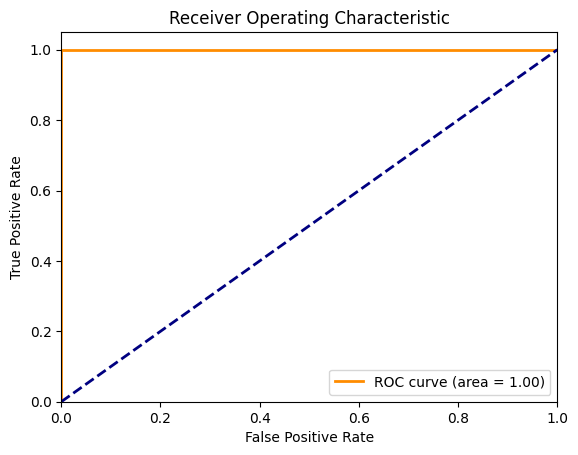

Confusion Matrix (Training Data):


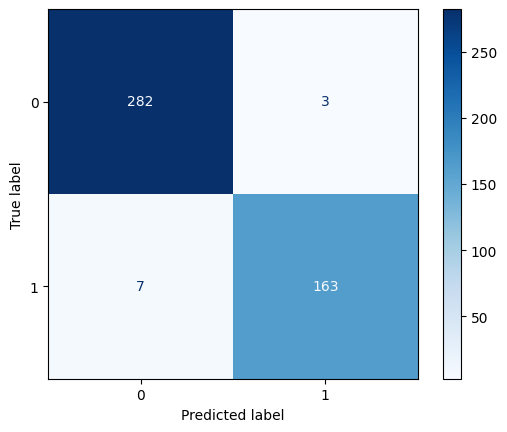

Confusion Matrix (Testing Data):


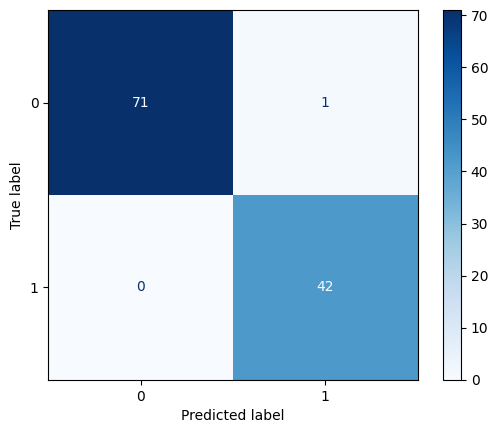

In [15]:
plot_roc_and_confusion_matrix(clf, X_train, y_train, X_test, y_test)


# ii. Semi-Supervised Learning/ Self-training:
select 50% of the positive class along with 50% of the negative class in the training set as labeled data
and the rest as unlabelled data. You can select them randomly.

A. Train an L1-penalized SVM to classify the labeled data Use normalized
data. Choose the penalty parameter using 5 fold cross validation.

B. Find the unlabeled data point that is the farthest to the decision boundary
of the SVM. Let the SVM label it (ignore its true label), and add it to
the labeled data, and retrain the SVM. Continue this process until all
unlabeled data are used. Test the  nal SVM on the test data andthe
average accuracy, precision, recall, F1-score, and AUC, for both training
and test sets over your M runs. Plot the ROC and report the confusion
matrix for training and testing in one of the runs.

In [16]:
\X = df.drop('Class', axis=1)
y = df['Class']

# Normalize the data to ensure all features contribute equally to the model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform 30 simulations to ensure robustness in model evaluation
for i in range(30):
    # Split the data into training and testing sets with stratification for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

    # Further split the training data into labeled and unlabeled datasets
    # Randomly select 50% of each class to be labeled data, the rest will be unlabeled
    X_train_labeled, X_train_unlabeled, y_train_labeled, y_train_unlabeled = [], [], [], []
    for label in y_train.unique():
        X_temp = X_train[y_train == label]
        y_temp = y_train[y_train == label]
        X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
        X_train_labeled.extend(X_labeled)
        X_train_unlabeled.extend(X_unlabeled)
        y_train_labeled.extend(y_labeled)
        y_train_unlabeled.extend(y_unlabeled)

    # Convert lists to NumPy arrays
    X_train_labeled = np.array(X_train_labeled)
    y_train_labeled = np.array(y_train_labeled)

    # Define and train the L1-penalized SVM on labeled data
    # L1 penalty for feature selection and sparsity
    svm = LinearSVC(penalty='l1', dual=False, max_iter=10000)

    # Set up GridSearchCV for hyperparameter tuning using 5-fold cross-validation
    parameters = {'C': [0.001, 0.01, 0.1, 1, 10]}
    clf = GridSearchCV(svm, parameters, cv=5)
    clf.fit(X_train_labeled, y_train_labeled)

    # Print the simulation number, the best score from cross-validation, and the best hyperparameters
    print("Simulation: ", i + 1)
    print("Best Score: ", clf.best_score_)
    print("Best Parameters: ", clf.best_params_)


Simulation:  1
Best Score:  0.9734299516908212
Best Parameters:  {'C': 1}
Simulation:  2
Best Score:  0.9735265700483092
Best Parameters:  {'C': 10}
Simulation:  3
Best Score:  0.9515942028985507
Best Parameters:  {'C': 0.1}
Simulation:  4
Best Score:  0.9603864734299516
Best Parameters:  {'C': 10}
Simulation:  5
Best Score:  0.9823188405797101
Best Parameters:  {'C': 0.1}
Simulation:  6
Best Score:  0.9869565217391305
Best Parameters:  {'C': 0.1}
Simulation:  7
Best Score:  0.973719806763285
Best Parameters:  {'C': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Simulation:  8
Best Score:  0.9602898550724639
Best Parameters:  {'C': 0.1}
Simulation:  9
Best Score:  0.982512077294686
Best Parameters:  {'C': 0.1}
Simulation:  10
Best Score:  0.9779710144927536
Best Parameters:  {'C': 0.1}
Simulation:  11
Best Score:  0.9735265700483092
Best Parameters:  {'C': 0.1}
Simulation:  12
Best Score:  0.9778743961352656
Best Parameters:  {'C': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Simulation:  13
Best Score:  0.9824154589371981
Best Parameters:  {'C': 0.1}
Simulation:  14
Best Score:  0.9735265700483092
Best Parameters:  {'C': 0.1}
Simulation:  15
Best Score:  0.9822222222222223
Best Parameters:  {'C': 0.1}
Simulation:  16
Best Score:  0.9735265700483092
Best Parameters:  {'C': 0.1}
Simulation:  17
Best Score:  0.9646376811594202
Best Parameters:  {'C': 0.1}
Simulation:  18
Best Score:  0.9647342995169084
Best Parameters:  {'C': 0.1}
Simulation:  19
Best Score:  0.9558454106280194
Best Parameters:  {'C': 0.1}
Simulation:  20
Best Score:  0.9649275362318841
Best Parameters:  {'C': 0.1}
Simulation:  21
Best Score:  0.9912077294685989
Best Parameters:  {'C': 0.1}
Simulation:  22
Best Score:  0.9779710144927536
Best Parameters:  {'C': 0.1}
Simulation:  23
Best Score:  0.9867632850241546
Best Parameters:  {'C': 1}
Simulation:  24
Best Score:  0.9647342995169084
Best Parameters:  {'C': 1}
Simulation:  25
Best Score:  0.982512077294686
Best Parameters:  {'C': 1}
Simula

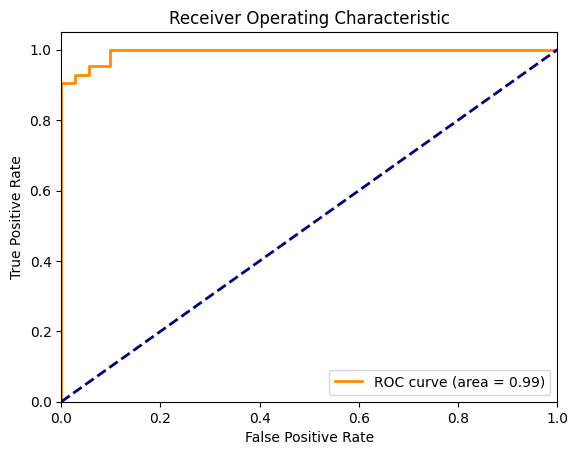

Confusion Matrix (Training Data):


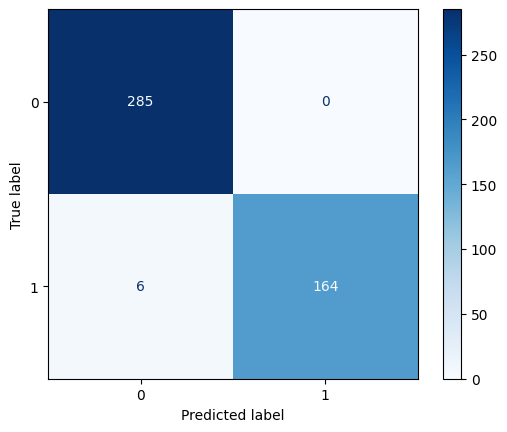

Confusion Matrix (Testing Data):


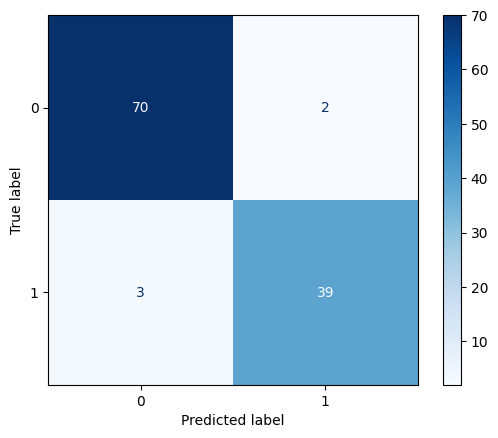

In [17]:
plot_roc_and_confusion_matrix(clf, X_train, y_train, X_test, y_test)


# iii. Unsupervised Learning:
Run k-means algorithm on the whole training
set. Ignore the labels of the data, and assume k = 2.

A. Run the k-means algorithm multiple times. Make sure that you initialize
the algoritm randomly. How do you make sure that the algorithm was
not trapped in a local minimum?

B. Compute the centers of the two clusters and  nd the closest 30 data
points to each center. Read the true labels of those 30 data points and
take a majority poll within them. The majority poll becomes the label
predicted by k-means for the members of each cluster. Then compare the
labels provided by k-means with the true labels of the training data and
report the average accuracy, precision, recall, F1-score, and AUC over M
runs, and ROC and the confusion matrix for one of the runs.

C. Classify test data based on their proximity to the centers of the clusters.
Report the average accuracy, precision, recall, F1-score, and AUC over
M runs, and ROC and the confusion matrix for one of the runs for the
test data.2

In [22]:
def calculate_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1_score': f1_score(y_true, y_pred, average='weighted'),
        'auc': roc_auc_score(y_true, y_pred)
    }

def plot_roc_and_cm(y_true, y_pred, title=""):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic {title}')
    plt.legend(loc="lower right")
    plt.show()

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
    plt.show()



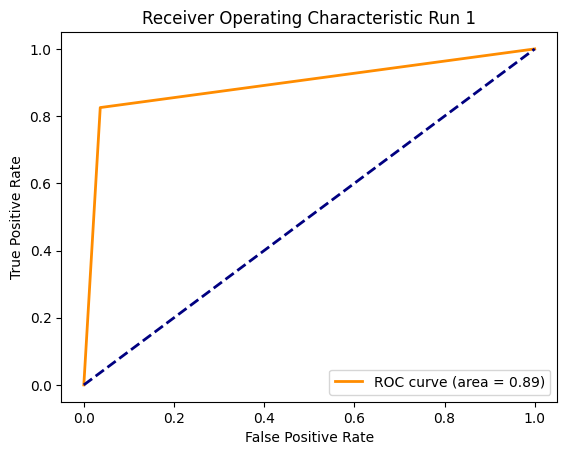

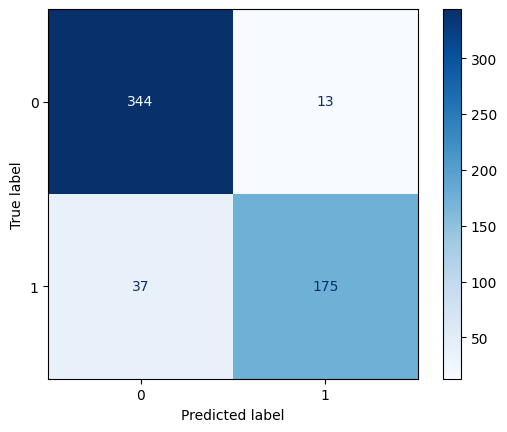

In [23]:
# Assuming df is your DataFrame and 'Class' is your target column
X = df.drop('Class', axis=1)
y = df['Class'].to_numpy()

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Number of runs
M = 30
average_metrics = []

for m in range(M):
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=m)
    kmeans.fit(X_scaled)

    centers = kmeans.cluster_centers_
    labels = np.empty(y.shape)

    for i in range(2):
        center = centers[i]
        distances = distance.cdist(X_scaled, [center], 'euclidean').squeeze()
        closest_indices = np.argsort(distances)[:30]
        majority_label = np.bincount(y[closest_indices]).argmax()
        labels[kmeans.labels_ == i] = majority_label

    metrics = calculate_metrics(y, labels)
    average_metrics.append(metrics)

    if m == 0:
        plot_roc_and_cm(y, labels, title=f"Run {m+1}")



In [24]:
# Compute average metrics
average_metrics = pd.DataFrame(average_metrics)
mean_metrics = average_metrics.mean()
print(mean_metrics)

accuracy     0.911072
precision    0.912109
recall       0.911072
f1_score     0.909886
auc          0.893688
dtype: float64


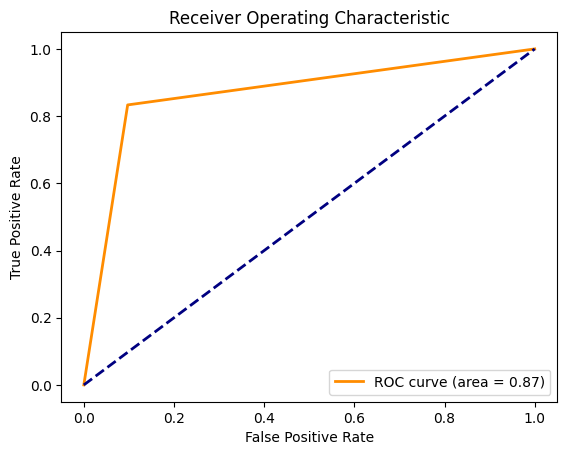

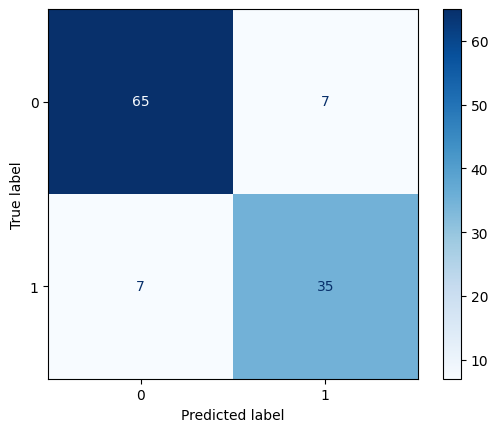

Average Test Metrics Over M Runs:
accuracy     0.905848
precision    0.906985
recall       0.905848
f1_score     0.904659
auc          0.889253
dtype: float64


In [25]:
def classify_based_on_proximity(X, centers, majority_labels):
    distances = distance.cdist(X, centers, 'euclidean')
    closest_cluster_indices = np.argmin(distances, axis=1)
    return np.array([majority_labels[i] for i in closest_cluster_indices])

X = df.drop('Class', axis=1)
y = df['Class'].to_numpy()

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Number of runs
M = 30
test_metrics = []

for m in range(M):
    # Split the data with stratification
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=m)

    # Train k-means
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=m)
    kmeans.fit(X_train)

    # Find majority labels for each cluster from training data
    majority_labels = []
    for i in range(2):
        cluster_indices = np.where(kmeans.labels_ == i)[0]
        majority_label = np.bincount(y_train[cluster_indices]).argmax()
        majority_labels.append(majority_label)

    # Classify test data
    y_pred_test = classify_based_on_proximity(X_test, kmeans.cluster_centers_, majority_labels)

    # Calculate and store metrics for test data
    test_metrics.append({
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test, average='weighted'),
        'recall': recall_score(y_test, y_pred_test, average='weighted'),
        'f1_score': f1_score(y_test, y_pred_test, average='weighted'),
        'auc': roc_auc_score(y_test, y_pred_test)
    })

    # Plot ROC and Confusion Matrix for one run
    if m == 0:
        fpr, tpr, _ = roc_curve(y_test, y_pred_test)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

        cm = confusion_matrix(y_test, y_pred_test)
        ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
        plt.show()

# Compute average metrics over all runs
average_test_metrics = pd.DataFrame(test_metrics).mean()
print("Average Test Metrics Over M Runs:")
print(average_test_metrics)


# 2. Active Learning Using Support Vector Machines
(a) Download the banknote authentication Data Set from: https://archive.ics.
uci.edu/ml/datasets/banknote+authentication. Choose 472 data points randomly as the test set, and the remaining 900 points as the training set. This is a binary classification problem.

In [36]:
# URL for the banknote authentication dataset file
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

# Send a GET request to download the dataset
response = requests.get(data_url)

# Define the path in Google Drive where the file will be saved
# Assuming you're storing it in a sub-folder within the CancerML folder
google_drive_path = '/content/drive/My Drive/CancerML/data_banknote_authentication.txt'

# Check if the request was successful
if response.status_code == 200:
    # Make sure the 'BanknoteAuthentication' folder exists or create it
    os.makedirs(os.path.dirname(google_drive_path), exist_ok=True)

    # Save the content of the request
    with open(google_drive_path, "wb") as file:
        file.write(response.content)
    success_message = "Banknote Authentication dataset downloaded successfully to Google Drive."
else:
    success_message = "Failed to download the Banknote Authentication dataset."

print(success_message)


Banknote Authentication dataset downloaded successfully to Google Drive.


In [38]:
# Path to the dataset file
file_path = '/content/drive/My Drive/CancerML/data_banknote_authentication.txt'

# Load the dataset
df = pd.read_csv(file_path, header=None)

# Split the dataset into training and test sets
# Randomly select 472 data points for the test set, and use the remaining 900 points as the training set
#train_df, test_df = train_test_split(df, test_size=472, train_size=900, random_state=42)



In [39]:
df

,0,1,2,3,4
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1
